# One Qubit Stochastic Solvers Test

Eric Giguere
Mai 2019

We demonstrate the numerical stability of different stochastic solver using a single qubit Rabi oscillation.

The issue was brought to our attention by Justin Dressel.   
This notebook is ispired by his tests:
https://github.com/justindressel/QuantumBayesian.jl/blob/master/notebooks/OneQubitStochasticTest.ipynb


In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
np.random.seed(11)

In [2]:
def plot_results(results):
    plt.plot(results.times, results.expect[0], label="x")
    plt.plot(results.times, results.expect[1], label="y")
    plt.plot(results.times, results.expect[2], label="z")
    plt.plot(results.times, results.expect[3], label=r"tr($\rho$)")
    plt.xlabel('time')
    plt.ylim(-5, 5)

    plt.legend()
    plt.show()

Consider a qubit orbiting in the x-z plane with continuous monitoring in the z axis.

In [3]:
times = np.linspace(0, 20, 201)
psi0 = qt.basis(2,0)
H = np.pi*qt.sigmay()
sc_ops = [(1/5)*qt.sigmaz()]

### Euler-Maruyama

First, lets do the evolution with the simplest method for integrating stochastic differential equation: **euler-maruyama**. 

Total run time:   0.09s


/home/eric/anaconda3/lib/python3.7/site-packages/qutip-4.4.0.dev0+42af593a-py3.7-linux-x86_64.egg/qutip/stochastic.py:1280: RuntimeWarning: overflow encountered in multiply
  data.ss += expect * expect
/home/eric/anaconda3/lib/python3.7/site-packages/qutip-4.4.0.dev0+42af593a-py3.7-linux-x86_64.egg/qutip/stochastic.py:1295: RuntimeWarning: invalid value encountered in true_divide
  data.expect = data.expect / nt


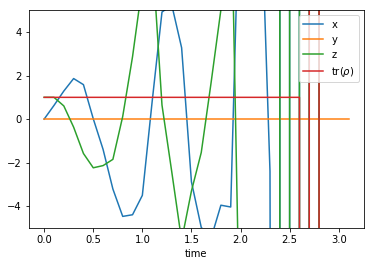

In [4]:
results = qt.smesolve(H, psi0, times, 
                      sc_ops=sc_ops, 
                      e_ops=[qt.sigmax(), qt.sigmay(), qt.sigmaz(),qt.qeye(2)],
                      solver="euler",noise=11, ntraj=1, options=qt.Options(store_states=True))

plot_results(results)

It is clear that the density matrix quickly becomes unphysical. The numerical error accumulated exponentially making the simulation impossible. 

In [5]:
results.states[0][4]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[-0.29127584  0.79167839]
 [ 0.79167839  1.29127584]]

In [6]:
results.states[0][32].full()

array([[-inf+nanj, -inf+nanj],
       [-inf+nanj,  inf+nanj]])

Reducing the integration step makes the simulation possible. However, with euler-maruyama's method, the error scale with $\delta t^{0.5}$.  
Therefore very small step are needed to obtain reliable results

Total run time:   0.11s


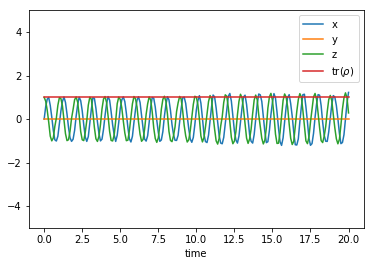

Total run time:   1.59s


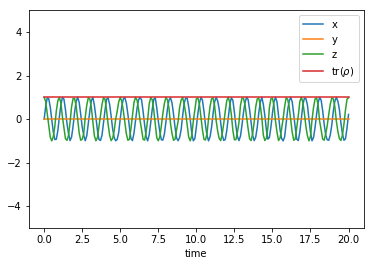

In [7]:
results_100 = qt.smesolve(H, psi0, times, sc_ops=sc_ops, 
                        e_ops=[qt.sigmax(), qt.sigmay(), qt.sigmaz(),qt.qeye(2)],
                        solver="euler",noise=11, ntraj=1, nsubsteps=100, 
                         options=qt.Options(store_states=True))

plot_results(results_100)
results_10000 = qt.smesolve(H, psi0, times, sc_ops=sc_ops, 
                         e_ops=[qt.sigmax(), qt.sigmay(), qt.sigmaz(),qt.qeye(2)],
                         solver="euler",noise=11, ntraj=1, nsubsteps=10000, 
                         options=qt.Options(store_states=True))

plot_results(results_10000)

In [8]:
results_100.states[0][-1].eigenenergies()

array([-0.12951738,  1.12951738])

In [9]:
results_10000.states[0][-1].eigenenergies()

array([-2.75948459e-04,  1.00027595e+00])

### Milstein

Next we uses **milstein**'s method. It's error scale with $\delta t$.

Total run time:   0.00s


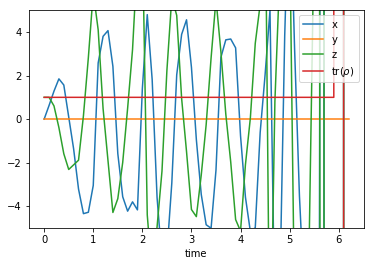

In [10]:
rez = qt.smesolve(H, psi0, times, sc_ops=sc_ops, 
                  e_ops=[qt.sigmax(), qt.sigmay(), qt.sigmaz(),qt.qeye(2)],
                  solver="milstein",noise=11)
plot_results(rez)

While somewhat better than euler, it still diverge badly and can not be used for our simulation without reducing the integration step.

Total run time:   0.11s


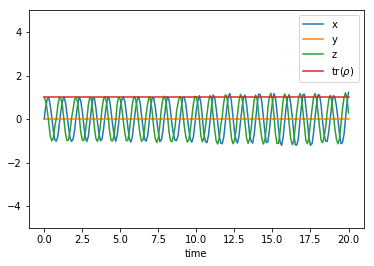

Total run time:   3.52s


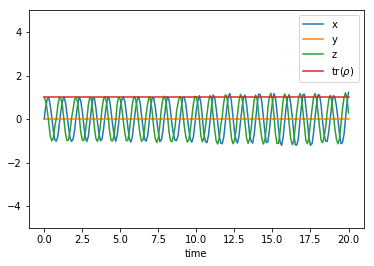

In [11]:
results_100 = qt.smesolve(H, psi0, times, sc_ops=sc_ops, 
                         e_ops=[qt.sigmax(), qt.sigmay(), qt.sigmaz(),qt.qeye(2)],
                         solver="milstein",noise=11, ntraj=1, nsubsteps=100, 
                         options=qt.Options(store_states=True))
plot_results(results_100)
results_10000 = qt.smesolve(H, psi0, times, sc_ops=sc_ops,
                          e_ops=[qt.sigmax(), qt.sigmay(), qt.sigmaz(),qt.qeye(2)],
                          solver="milstein",noise=11, ntraj=1, nsubsteps=10000, 
                          options=qt.Options(store_states=True))
plot_results(results_100)

In [12]:
results_100.states[0][-1].eigenenergies()

array([-0.13194608,  1.13194608])

In [13]:
results_10000.states[0][-1].eigenenergies()

array([-3.53049780e-04,  1.00035305e+00])

Milstein method is not much an improvement over euler in this case.  
There are many solver of order 1. They have different characteristic and can behave quite differently.

In [14]:
for solver in ['milstein', 'milstein-imp', 'platen', 'pc-euler', 'pc-euler-imp']:
    print(solver)
    results_100 = qt.smesolve(H, psi0, times, sc_ops=sc_ops, 
                             e_ops=[qt.sigmax(), qt.sigmay(), qt.sigmaz(),qt.qeye(2)],
                             solver=solver,noise=11, ntraj=1, nsubsteps=100, 
                             options=qt.Options(store_states=True))
    print(results_100.states[0][-1].eigenenergies(), "\n")

milstein
Total run time:   0.12s
[-0.13194608  1.13194608] 

milstein-imp
Total run time:   4.53s
[-0.00167414  1.00167414] 

platen
Total run time:   0.17s
[-4.82935387e-05  1.00004829e+00] 

pc-euler
Total run time:   0.13s
[-0.13092491  1.13092491] 

pc-euler-imp
Total run time:   0.15s
[-1.92150119e-05  1.00001922e+00] 



# Taylor
Higher order stochatic solver available in qutip are 'taylor1.5', 'taylor1.5-imp', 'explicit1.5', 'taylor2.0'.
Taylor1.5 is the default solver for smesolve and ssesolve. It is fast and work with multiple commuting sc_ops and time dependant Hamiltonian. 

Total run time:   0.08s
[-1.71337404  2.71337404] 



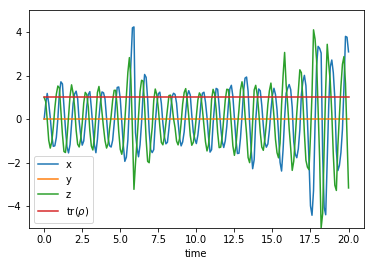

Total run time:   0.12s
[1.14793086e-04 9.99885207e-01] 



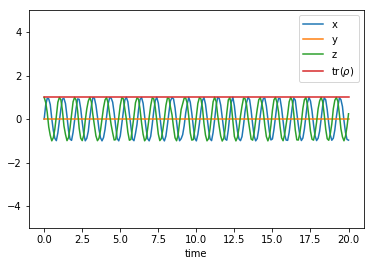

In [15]:
results_1 = qt.smesolve(H, psi0, times, sc_ops=sc_ops, 
                  e_ops=[qt.sigmax(), qt.sigmay(), qt.sigmaz(), qt.qeye(2)],
                  solver="taylor1.5",noise=11, ntraj=1, 
                             options=qt.Options(store_states=True))
print(results_1.states[0][-1].eigenenergies(), "\n")
plot_results(results_1)
results_10 = qt.smesolve(H, psi0, times, sc_ops=sc_ops, 
                  e_ops=[qt.sigmax(), qt.sigmay(), qt.sigmaz(), qt.qeye(2)],
                  solver="taylor1.5",noise=11, ntraj=1, nsubsteps=10, 
                             options=qt.Options(store_states=True))
print(results_10.states[0][-1].eigenenergies(), "\n")
plot_results(results_10)

taylor1.5 can produce reliable with bigger timestep than previous solver.

In [16]:
for solver in ['taylor1.5', 'taylor1.5-imp', 'explicit1.5', 'taylor2.0']:
    print(solver)
    results_100 = qt.smesolve(H, psi0, times, sc_ops=sc_ops, 
                             e_ops=[qt.sigmax(), qt.sigmay(), qt.sigmaz(),qt.qeye(2)],
                             solver=solver,noise=11, ntraj=1, nsubsteps=100, 
                             options=qt.Options(store_states=True))
    print(results_100.states[0][-1].eigenenergies(), "\n")

taylor1.5
Total run time:   0.38s
[-3.60640305e-05  1.00003606e+00] 

taylor1.5-imp
Total run time:   4.93s
[-1.53863043e-05  1.00001539e+00] 

explicit1.5
Total run time:   0.44s
[1.50854336e-05 9.99984915e-01] 

taylor2.0
Total run time:   0.36s
[2.28725707e-06 9.99997713e-01] 



## Rouchon

Lastly we have rouchon's method. This method has a numerical error scaling with $\delta t$. However it has been build in a way to preserve the physicality of the density matrix. 

Total run time:   0.09s


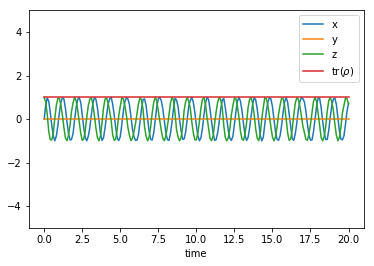

[1.14793086e-04 9.99885207e-01]


In [17]:
results = qt.smesolve(H, psi0, times, sc_ops=sc_ops, 
                      e_ops=[qt.sigmax(), qt.sigmay(), qt.sigmaz(),qt.qeye(2)],
                      solver="rouchon",noise=11, ntraj=1, 
                      options=qt.Options(store_states=True))
plot_results(results)
print(results_10.states[0][-1].eigenenergies())

In [18]:
qt.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) 2011 and later.
A. J. Pitchford, P. D. Nation, R. J. Johansson, A. Grimsmo, and C. Granade

QuTiP Version:      4.4.0.dev0+42af593a
Numpy Version:      1.16.2
Scipy Version:      1.2.1
Cython Version:     0.29.6
Matplotlib Version: 3.0.3
Python Version:     3.7.3
Number of CPUs:     3
BLAS Info:          INTEL MKL
OPENMP Installed:   False
INTEL MKL Ext:      True
Platform Info:      Linux (x86_64)
Installation path:  /home/eric/anaconda3/lib/python3.7/site-packages/qutip-4.4.0.dev0+42af593a-py3.7-linux-x86_64.egg/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
